In [1]:
# Credict Classifications 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
credit_df = pd.read_csv( "German Credit Data.csv" )
credit_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
checkin_acc          1000 non-null object
duration             1000 non-null int64
credit_history       1000 non-null object
amount               1000 non-null int64
savings_acc          1000 non-null object
present_emp_since    1000 non-null object
inst_rate            1000 non-null int64
personal_status      1000 non-null object
residing_since       1000 non-null int64
age                  1000 non-null int64
inst_plans           1000 non-null object
num_credits          1000 non-null int64
job                  1000 non-null object
status               1000 non-null int64
dtypes: int64(7), object(7)
memory usage: 109.5+ KB


In [2]:
credit_df.iloc[0:5,1:7] 

,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate
0,6,A34,1169,A65,A75,4
1,48,A32,5951,A61,A73,2
2,12,A34,2096,A61,A74,2
3,42,A32,7882,A61,A74,2
4,24,A33,4870,A61,A73,3


In [3]:
credit_df.iloc[0:5,7:] 

,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A93,4,67,A143,2,A173,0
1,A92,2,22,A143,1,A173,1
2,A93,3,49,A143,1,A172,0
3,A93,4,45,A143,1,A173,0
4,A93,4,53,A143,2,A173,1


In [4]:
import pandas_profiling 

In [5]:
pfr = pandas_profiling.ProfileReport(credit_df)
pfr.to_file(" German.html")

In [6]:
credit_df.status.value_counts() 

0    700
1    300
Name: status, dtype: int64

In [7]:
X_features = list( credit_df.columns )
X_features.remove( 'status' )
X_features 

['checkin_acc',
 'duration',
 'credit_history',
 'amount',
 'savings_acc',
 'present_emp_since',
 'inst_rate',
 'personal_status',
 'residing_since',
 'age',
 'inst_plans',
 'num_credits',
 'job']

###  Encoding Categorical Features 

In [8]:
encoded_credit_df = pd.get_dummies( credit_df[X_features],
drop_first = True ) 

In [10]:
encoded_credit_df.columns

Index(['duration', 'amount', 'inst_rate', 'residing_since', 'age',
       'num_credits', 'checkin_acc_A12', 'checkin_acc_A13', 'checkin_acc_A14',
       'credit_history_A31', 'credit_history_A32', 'credit_history_A33',
       'credit_history_A34', 'savings_acc_A62', 'savings_acc_A63',
       'savings_acc_A64', 'savings_acc_A65', 'present_emp_since_A72',
       'present_emp_since_A73', 'present_emp_since_A74',
       'present_emp_since_A75', 'personal_status_A92', 'personal_status_A93',
       'personal_status_A94', 'inst_plans_A142', 'inst_plans_A143', 'job_A172',
       'job_A173', 'job_A174'],
      dtype='object')

In [11]:
list(encoded_credit_df.columns) 


['duration',
 'amount',
 'inst_rate',
 'residing_since',
 'age',
 'num_credits',
 'checkin_acc_A12',
 'checkin_acc_A13',
 'checkin_acc_A14',
 'credit_history_A31',
 'credit_history_A32',
 'credit_history_A33',
 'credit_history_A34',
 'savings_acc_A62',
 'savings_acc_A63',
 'savings_acc_A64',
 'savings_acc_A65',
 'present_emp_since_A72',
 'present_emp_since_A73',
 'present_emp_since_A74',
 'present_emp_since_A75',
 'personal_status_A92',
 'personal_status_A93',
 'personal_status_A94',
 'inst_plans_A142',
 'inst_plans_A143',
 'job_A172',
 'job_A173',
 'job_A174']

In [12]:
import statsmodels.api as sm

In [13]:
encoded_credit_df[['checkin_acc_A12',
'checkin_acc_A13',
'checkin_acc_A14']].head(5) 

,checkin_acc_A12,checkin_acc_A13,checkin_acc_A14
0,0,0,0
1,1,0,0
2,0,0,1
3,0,0,0
4,0,0,0


In [14]:
import statsmodels.api as sm
Y = credit_df.status
X = sm.add_constant( encoded_credit_df ) 


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
Y,
test_size = 0.3,
random_state = 42) 

In [16]:
import statsmodels.api as sm
logit = sm.Logit(y_train, X_train)
logit_model = logit.fit() 

Optimization terminated successfully.
         Current function value: 0.488938
         Iterations 6


In [17]:
def get_significant_vars( lm ):
 var_p_vals_df = pd.DataFrame( lm.pvalues )
 var_p_vals_df['vars'] = var_p_vals_df.index
 var_p_vals_df.columns = ['pvals', 'vars']
 return list( var_p_vals_df[var_p_vals_df.pvals <= 0.05]['vars'] ) 

In [18]:
significant_vars = get_significant_vars( logit_model )
significant_vars 

['duration',
 'amount',
 'inst_rate',
 'age',
 'checkin_acc_A13',
 'checkin_acc_A14',
 'credit_history_A34',
 'savings_acc_A65']

In [19]:
final_logit = sm.Logit( y_train,
sm.add_constant( X_train[significant_vars] ) ).fit() 

Optimization terminated successfully.
         Current function value: 0.511350
         Iterations 6


In [20]:
final_logit.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:               Logit            Pseudo R-squared: 0.161     
Dependent Variable:  status           AIC:              733.8898  
Date:                2019-08-17 22:29 BIC:              774.8495  
No. Observations:    700              Log-Likelihood:   -357.94   
Df Model:            8                LL-Null:          -426.75   
Df Residuals:        691              LLR p-value:      7.4185e-26
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -0.8969   0.4364 -2.0551 0.0399 -1.7523 -0.0415
duration            0.0197   0.0098  2.0033 0.0451  0.0004  0.0390
amount              0.0001   0.0000  2.3205 0.0203  0.0000  0.0002
inst_rate           0.2811   0.0929  3.0264 0.0025  0.0991  0.4632
age                -0.0216   0.0089 -2.4207 0.0155 -0.0392 -0.0041
checkin_acc_A13    -0.8038   0.4081 -1.9697 0.0489 -1.6037 -0.0040
checkin_acc_A14    -1.5452   0.2187 -7.0649 0.0000 -1.9738 -1.1165
credit_history_A34 -0.8781   0.2319 -3.7858 0.0002 -1.3327 -0.4235
savings_acc_A65    -0.5448   0.2581 -2.1108 0.0348 -1.0507 -0.0389
==================================================================

"""

In [21]:
y_pred_df = pd.DataFrame( { "actual": y_test,
"predicted_prob": final_logit.predict(
sm.add_constant( X_test[significant_vars] ) ) } ) 

In [22]:
y_pred_df.sample(10, random_state = 42)

,actual,predicted_prob
557,1,0.080493
798,0,0.076653
977,0,0.345979
136,0,0.249919
575,0,0.062264
544,0,0.040768
332,1,0.833093
917,1,0.370667
678,0,0.388392
363,0,0.088952


In [23]:
y_pred_df['predicted'] = y_pred_df.predicted_prob.map(
lambda x: 1 if x > 0.5 else 0)
y_pred_df.sample(10, random_state = 42) 

,actual,predicted_prob,predicted
557,1,0.080493,0
798,0,0.076653,0
977,0,0.345979,0
136,0,0.249919,0
575,0,0.062264,0
544,0,0.040768,0
332,1,0.833093,1
917,1,0.370667,0
678,0,0.388392,0
363,0,0.088952,0


In [24]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from sklearn import metrics 

In [25]:
def draw_cm( actual, predicted ):
 ## Cret
 cm = metrics.confusion_matrix( actual, predicted, [1,0] )
 sn.heatmap(cm, annot=True, fmt='.2f',
xticklabels = ["Bad credit", "Good Credit"] ,
yticklabels = ["Bad credit", "Good Credit"] )
 plt.ylabel('True label')
 plt.xlabel('Predicted label')
 plt.show() 

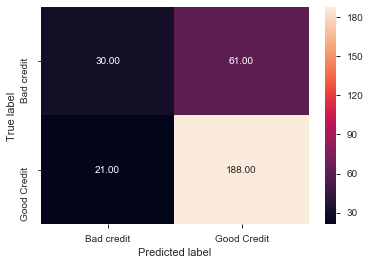

In [26]:
draw_cm( y_pred_df.actual,
y_pred_df.predicted ) 

In [27]:
print( metrics.classification_report( y_pred_df.actual,
y_pred_df.predicted ) ) 

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       209
           1       0.59      0.33      0.42        91

    accuracy                           0.73       300
   macro avg       0.67      0.61      0.62       300
weighted avg       0.70      0.73      0.70       300



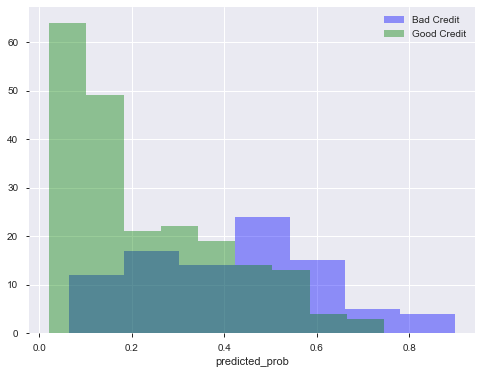

In [28]:
plt.figure( figsize = (8,6) )
sn.distplot( y_pred_df[y_pred_df.actual == 1]["predicted_prob"],
kde=False, color = 'b',
label = 'Bad Credit' )
sn.distplot( y_pred_df[y_pred_df.actual == 0]["predicted_prob"],
kde=False, color = 'g',
label = 'Good Credit' )
plt.legend()
plt.show() 

In [29]:
def draw_roc( actual, probs ):
 fpr, \
 tpr, \
 thresholds = metrics.roc_curve( actual,
probs,
drop_intermediate = False )
 auc_score = metrics.roc_auc_score( actual, probs )
 plt.figure(figsize=(8, 6))
 plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
 plt.plot([0, 1], [0, 1], 'k--')
 plt.xlim([0.0, 1.0])
 plt.ylim([0.0, 1.05])
 plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
 plt.ylabel('True Positive Rate')
 plt.legend(loc="lower right")
 plt.show()
 return fpr, tpr, thresholds 


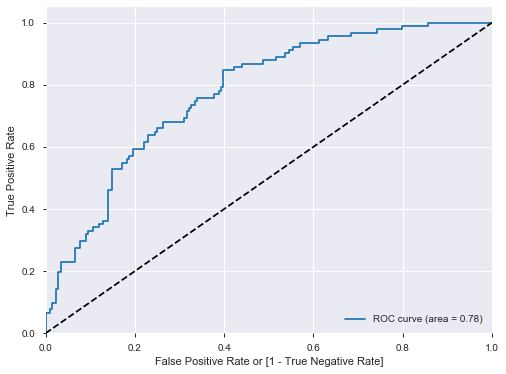

In [30]:
fpr, tpr, thresholds = draw_roc( y_pred_df.actual,
y_pred_df.predicted_prob) 

In [31]:
auc_score = metrics.roc_auc_score( y_pred_df.actual,
y_pred_df.predicted_prob )
round( float( auc_score ), 2 ) 

0.78

In [32]:
tpr_fpr = pd.DataFrame( { 'tpr': tpr,
'fpr': fpr,
'thresholds': thresholds } )
tpr_fpr['diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values( 'diff', ascending = False )[0:5] 

,tpr,fpr,thresholds,diff
160,0.846154,0.397129,0.221534,0.449025
161,0.846154,0.401914,0.216531,0.444240
162,0.846154,0.406699,0.215591,0.439455
159,0.835165,0.397129,0.223980,0.438036
166,0.857143,0.421053,0.207107,0.436090


In [33]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(
lambda x: 1 if x > 0.22 else 0) 

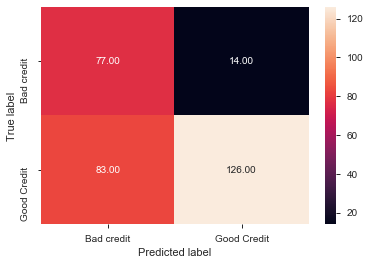

In [34]:
draw_cm( y_pred_df.actual,
y_pred_df.predicted_new) 

In [35]:
print(metrics.classification_report( y_pred_df.actual,
y_pred_df.predicted_new )) 

              precision    recall  f1-score   support

           0       0.90      0.60      0.72       209
           1       0.48      0.85      0.61        91

    accuracy                           0.68       300
   macro avg       0.69      0.72      0.67       300
weighted avg       0.77      0.68      0.69       300



In [36]:
def get_total_cost( actual, predicted, cost_FPs, cost_FNs ):
 cm = metrics.confusion_matrix( actual, predicted, [1,0] )
 cm_mat = np.array( cm )
 return cm_mat[0,1] * cost_FNs + cm_mat[1,0] * cost_FPs 

In [37]:
cost_df = pd.DataFrame( columns = ['prob', 'cost']) 


In [38]:
idx = 0
## iterate cut-off probability values between 0.1 and 0.5
for each_prob in range( 10, 50):
 cost = get_total_cost( y_pred_df.actual,
y_pred_df.predicted_prob.map(
lambda x: 1 if x > (each_prob/100) else 0), 1, 5 )
 cost_df.loc[idx] = [(each_prob/100), cost]
 idx += 1 

In [39]:
cost_df.sort_values( 'cost', ascending = True )[0:5] 

,prob,cost
4,0.14,150.0
12,0.22,153.0
2,0.12,154.0
10,0.20,154.0
9,0.19,156.0


In [40]:
y_pred_df['predicted_using_cost'] = y_pred_df.predicted_prob.map(
 lambda x: 1 if x > 0.14 else 0) 

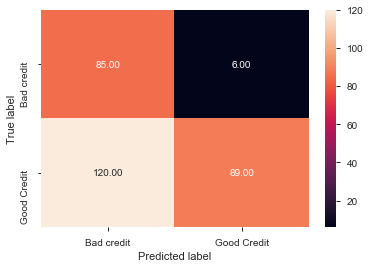

In [41]:
draw_cm( y_pred_df.actual,
y_pred_df.predicted_using_cost ) 

In [42]:
import pandas as pd
bank_df = pd.read_csv( 'bank.csv' )
bank_df.head( 5 ) 

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [43]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
age                  4521 non-null int64
job                  4521 non-null object
marital              4521 non-null object
education            4521 non-null object
default              4521 non-null object
balance              4521 non-null int64
housing-loan         4521 non-null object
personal-loan        4521 non-null object
current-campaign     4521 non-null int64
previous-campaign    4521 non-null int64
subscribed           4521 non-null object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


In [44]:
X_features = list( bank_df.columns )
X_features.remove( 'subscribed' )
X_features 

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [45]:
encoded_bank_df = pd.get_dummies( bank_df[X_features],
drop_first = True ) 

In [46]:
Y = bank_df.subscribed.map( lambda x: int( x == 'yes') )
X = encoded_bank_df 

In [47]:
logit_model = sm.Logit( Y, sm.add_constant( X ) ).fit() 

Optimization terminated successfully.
         Current function value: 0.335572
         Iterations 7


In [48]:
logit_model.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Pseudo R-squared: 0.061     
Dependent Variable:   subscribed       AIC:              3082.2384 
Date:                 2019-08-17 22:35 BIC:              3236.2341 
No. Observations:     4521             Log-Likelihood:   -1517.1   
Df Model:             23               LL-Null:          -1615.5   
Df Residuals:         4497             LLR p-value:      1.4866e-29
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const               -1.7573   0.3799 -4.6251 0.0000 -2.5019 -1.0126
age                  0.0078   0.0058  1.3395 0.1804 -0.0036  0.0191
balance             -0.0000   0.0000 -0.2236 0.8231 -0.0000  0.0000
current-campaign    -0.0905   0.0238 -3.8042 0.0001 -0.1371 -0.0439
previous-campaign    0.1414   0.0212  6.6569 0.0000  0.0998  0.1830
job_blue-collar     -0.3412   0.2000 -1.7060 0.0880 -0.7331  0.0508
job_entrepreneur    -0.2900   0.3161 -0.9175 0.3589 -0.9096  0.3295
job_housemaid       -0.0166   0.3339 -0.0497 0.9603 -0.6711  0.6379
job_management      -0.0487   0.1984 -0.2455 0.8061 -0.4375  0.3401
job_retired          0.5454   0.2503  2.1794 0.0293  0.0549  1.0360
job_self-employed   -0.2234   0.2895 -0.7715 0.4404 -0.7909  0.3441
job_services        -0.2248   0.2245 -1.0012 0.3167 -0.6648  0.2152
job_student          0.3888   0.3181  1.2223 0.2216 -0.2346  1.0122
job_technician      -0.2101   0.1874 -1.1213 0.2622 -0.5773  0.1571
job_unemployed      -0.3723   0.3336 -1.1162 0.2643 -1.0261  0.2815
job_unknown          0.3193   0.4620  0.6913 0.4894 -0.5861  1.2248
marital_married     -0.4012   0.1440 -2.7857 0.0053 -0.6835 -0.1189
marital_single      -0.0463   0.1676 -0.2763 0.7823 -0.3749  0.2822
education_secondary  0.2128   0.1680  1.2670 0.2052 -0.1164  0.5420
education_tertiary   0.3891   0.1935  2.0103 0.0444  0.0098  0.7684
education_unknown   -0.1956   0.2927 -0.6682 0.5040 -0.7693  0.3781
default_yes          0.2286   0.3670  0.6228 0.5334 -0.4908  0.9479
housing-loan_yes    -0.5355   0.1024 -5.2273 0.0000 -0.7362 -0.3347
personal-loan_yes   -0.7139   0.1689 -4.2268 0.0000 -1.0449 -0.3829
===================================================================

"""

In [49]:
significant_vars = get_significant_vars( logit_model )
significant_vars 

['const',
 'current-campaign',
 'previous-campaign',
 'job_retired',
 'marital_married',
 'education_tertiary',
 'housing-loan_yes',
 'personal-loan_yes']

In [50]:
X_features = ['current-campaign',
'previous-campaign',
'job_retired',
'marital_married',
'education_tertiary',
'housing-loan_yes',
'personal-loan_yes'] 

In [51]:
logit_model_2 = sm.Logit( Y, sm.add_constant( X[X_features] ) ).fit() 

Optimization terminated successfully.
         Current function value: 0.337228
         Iterations 7


In [52]:
y_pred_df = pd.DataFrame( { 'actual': Y,
'predicted_prob': logit_model_2.predict(
sm.add_constant( X[X_features] ) ) } )
sorted_predict_df = y_pred_df[['predicted_prob',
'actual']].sort_values( 'predicted_prob',
ascending = False ) 

In [53]:
num_per_decile = int( len( sorted_predict_df ) / 10 )
print( "Number of observations per decile: ", num_per_decile) 

Number of observations per decile:  452


In [57]:
def get_deciles( df ):
    df['decile'] = 1
    idx = 0
    for each_d in range( 0, 10 ):
        df.iloc[idx:idx+num_per_decile, df.columns.get_loc('decile')] = each_d
        idx += num_per_decile
    df['decile'] = df['decile'] + 1
    return df 

In [58]:
deciles_predict_df = get_deciles( sorted_predict_df ) 

In [59]:
deciles_predict_df[0:10] 

,predicted_prob,actual,decile
3682,0.864769,0,1
97,0.828031,0,1
3426,0.706809,0,1
1312,0.642337,1,1
3930,0.631032,1,1
4397,0.619146,0,1
2070,0.609129,0,1
3023,0.573199,0,1
4080,0.572364,0,1
804,0.559350,0,1


In [60]:
gain_lift_df = pd.DataFrame(
 deciles_predict_df.groupby(
'decile')['actual'].sum() ).reset_index()
gain_lift_df.columns = ['decile', 'gain'] 

In [61]:
gain_lift_df['gain_percentage'] = (100 *
gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum()) 

In [62]:
gain_lift_df 

,decile,gain,gain_percentage
0,1,125,23.992322
1,2,83,39.923225
2,3,73,53.934741
3,4,53,64.107486
4,5,31,70.057582
5,6,46,78.886756
6,7,37,85.988484
7,8,28,91.362764
8,9,25,96.161228
9,10,20,100.000000


In [63]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline 

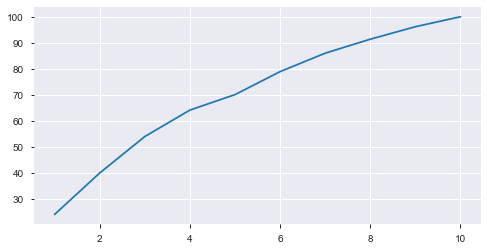

In [64]:
plt.figure( figsize = (8,4))
plt.plot( gain_lift_df['decile'],
gain_lift_df['gain_percentage'], '-' )
plt.show() 

In [65]:
gain_lift_df['lift'] = ( gain_lift_df.gain_percentage
/ ( gain_lift_df.decile * 10) ) 

In [66]:
gain_lift_df 

,decile,gain,gain_percentage,lift
0,1,125,23.992322,2.399232
1,2,83,39.923225,1.996161
2,3,73,53.934741,1.797825
3,4,53,64.107486,1.602687
4,5,31,70.057582,1.401152
5,6,46,78.886756,1.314779
6,7,37,85.988484,1.228407
7,8,28,91.362764,1.142035
8,9,25,96.161228,1.068458
9,10,20,100.000000,1.000000


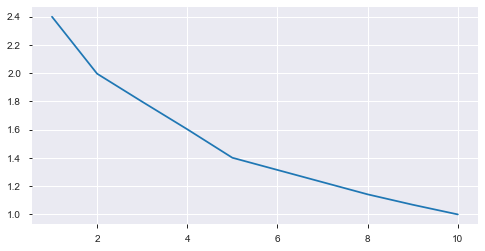

In [67]:
plt.figure( figsize = (8,4))
plt.plot( gain_lift_df['decile'], gain_lift_df['lift'], '-' )
plt.show() 

# 5.5 Decision Trees

## Split the data set

In [69]:
Y = credit_df.status
X = encoded_credit_df
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y,
test_size = 0.3,
random_state = 42) 

## 5.5.2 Building Decision Tree classifier using Gini Criteria

In [70]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion = 'gini',
max_depth = 3 ) 

In [71]:
clf_tree.fit( X_train, y_train ) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## 5.5.3 Measuring Test Accuracy

In [72]:
tree_predict = clf_tree.predict( X_test )
metrics.roc_auc_score( y_test, tree_predict ) 

0.5835743204164258

## 5.5.4 Displaying the Tree

In [73]:
from sklearn.tree import export_graphviz
import pydotplus as pdot
from IPython.display import Image
# Export the tree into odt file
export_graphviz( clf_tree,
out_file = "chd_tree.odt",
feature_names = X_train.columns,
class_names= ['Good Credit', 'Bad Credit'],
filled = True)
# Read the create the image file
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'chd_tree.odt' )
chd_tree_graph.write_jpg( 'chd_tree.png' )
# Render the png file
Image(filename='chd_tree.png') 


InvocationException: GraphViz's executables not found

## 5.5.5 Understanding Gini Impurity

In [74]:
gini_node_1 = 1 - pow(491/700, 2) - pow (209/700, 2)
print( round( gini_node_1, 4) ) 

0.4189


In [75]:
X_test.shape 

(300, 29)

## 5.5.6 Building Decision Tree using Entropy Criteria

In [76]:
clf_tree_entropy = DecisionTreeClassifier( criterion = 'entropy',
max_depth = 3 )
clf_tree_entropy.fit( X_train, y_train )
# Export the tree into odt file
export_graphviz( clf_tree_entropy,
out_file = "chd_tree_entropy.odt",
feature_names = X_train.columns,
filled = True )
# Read the create the image file
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'chd_tree_entropy.odt' )
chd_tree_graph.write_jpg( 'chd_tree_entropy.png' )
# Render the png file
Image(filename='chd_tree_entropy.png') 

InvocationException: GraphViz's executables not found

## Calculating entropy impurity

In [79]:
import math
entropy_node_1 = - (491/700) * math.log2(491/700) - (209/700) * math.log2(209/700)
print( round( entropy_node_1, 2) ) 

0.88


## Measuring test accuracy


In [80]:
tree_predict = clf_tree_entropy.predict( X_test )
metrics.roc_auc_score( y_test, tree_predict ) 

0.5763972869236027

# 5.5.7 Finding optimal criteria and max_depth

In [81]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'criterion': ['gini','entropy'],
'max_depth': range(2,10)}]
clf_tree = DecisionTreeClassifier()
clf = GridSearchCV(clf_tree,
tuned_parameters,
cv=10,
scoring='roc_auc')
clf.fit(X_train, y_train ) 

C:\Users\thyagaraj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 10)}],
             pre_dis

In [82]:
clf.best_score_ 


0.6824299319727891

In [83]:
clf.best_params_ 

{'criterion': 'gini', 'max_depth': 2}